# Reto Empresarial - Ejercicio Metaparámetros - Daniel Afanador


In [1]:
#--- Usamos nuevamente el dataset de MNIST
#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('mnist/train/*/*.png')
valid_files = glob('mnist/valid/*/*.png')
test_files = glob('mnist/test/*/*.png')

train_files[0]

'mnist/train/1/6783.png'

In [2]:
#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

In [3]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[2]) )
  X_train.append(np.array(Image.open(train_file)))

In [4]:
#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[2]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [5]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[2]) )
  X_test.append( np.array(Image.open(test_file)) )

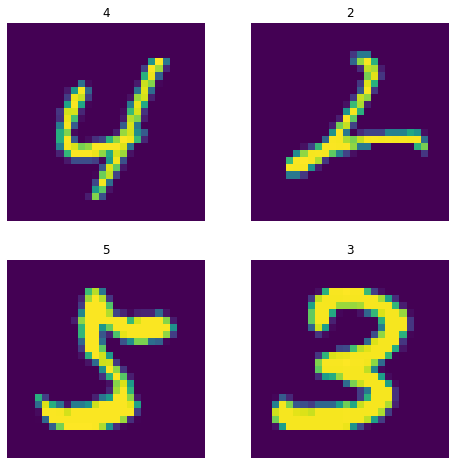

In [6]:
#-- Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [7]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

# Batch Size: Modelo ANN **1**

In [77]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

batch_size = 512
train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [78]:
#--- Definimos una ANN simple sin utilizar batch_size

input_dim = 28*28
out_dim = 10
hidden = 100

learning_rate = 0.001
weight_decay = 0.001

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.Tanh(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

In [79]:
from sklearn.metrics import f1_score

n_epoch = 50

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

total_it = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    model.train()

    Xtr = X_train_batch.view(X_train_batch.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train_batch,Y_pred, average='macro') )
  
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

    total_it += 1
  if((epoch+1)%10==0):
    print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch, loss_train[-1], f1_train[-1], acc_train[-1]) )

Epoch [10/50], loss: 0.2962300181388855. f1:0.9060076801658499 acc: 0.907608687877655 
Epoch [20/50], loss: 0.2611534297466278. f1:0.9008051089195895 acc: 0.9021739363670349 
Epoch [30/50], loss: 0.23321740329265594. f1:0.9225745971723105 acc: 0.9239130616188049 
Epoch [40/50], loss: 0.17821349203586578. f1:0.9404152119278638 acc: 0.9402173757553101 
Epoch [50/50], loss: 0.20771020650863647. f1:0.9348831029604575 acc: 0.9347826242446899 


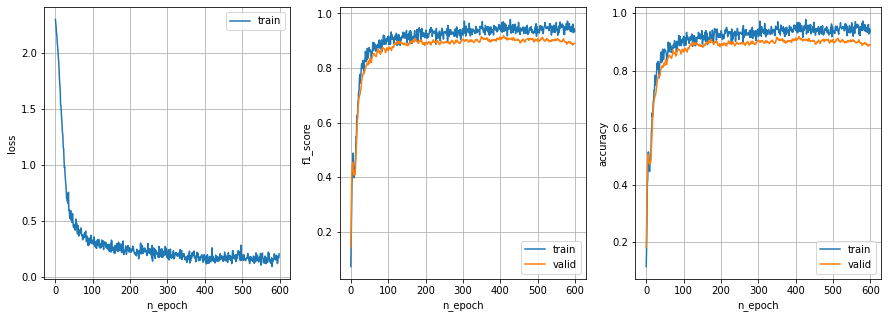

In [80]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(total_it), loss_train, label='train')
# plt.plot(range(total_it), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(total_it), f1_train, label='train')
plt.plot(range(total_it), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(total_it), acc_train, label='train')
plt.plot(range(total_it), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

In [81]:
#-- Evaluamos el modelo entrenado con el set de testeo
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.35719555616378784, f1: 0.8870922225838541, acc: 0.8881048560142517


**Para el primer modelo, configurado por los metaparámetros $(\text{n_epoch}, \text{learning_rate}, \text{weight_decay}, \text{batch_size}) = (50, 0.001, 0.001, 512)$, se obtienen scores con un** *loss* **considerable, pero relativamente pequeño, mientras que los scores** *f_1* **y** *accuracy* **son mayores a 0.9, lo cual muestra que este modelo se halla optimizado.**

In [82]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

In [83]:
from sklearn.metrics import f1_score

def train_valid(model, n_epoch, optimizer, criterion):
  loss_train = []
  f1_train = []
  acc_train = []

  loss_valid = []
  f1_valid = []
  acc_valid = []

  for epoch in range(n_epoch):
    model.train()

    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

  print( 'Valid Evaluation loss: {}. f1:{} acc: {} '.format(loss_valid[-1], f1_valid[-1], acc_valid[-1]) )
  CM(Y_valid, Y_pred, 10)

  0%|          | 0/1 [00:00<?, ?it/s]

ne: 50, hd:100, wd:0.001, lr: 0.001, bs:512 
Valid Evaluation loss: 0.7152563333511353. f1:0.8388807212616192 acc: 0.8399999737739563 


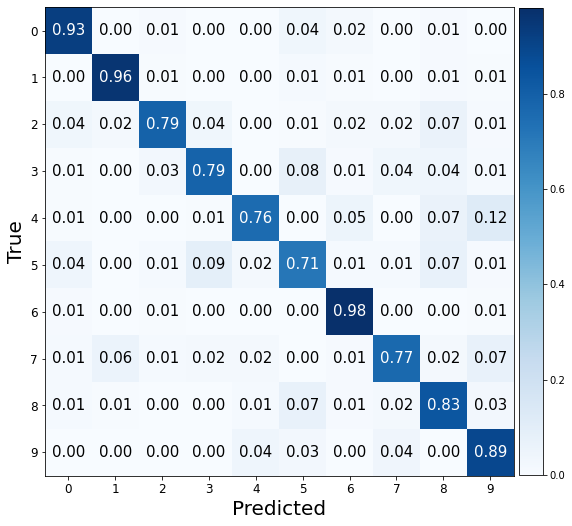

###################



In [84]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm


bs_list = [512]
lr_list = [0.001]
wd_list = [0.001]
hd_list = [100]
ne_list = [50]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(hd_list)*len(ne_list))

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        for hd in hd_list:
          input_dim = 28*28
          out_dim = 10
          hidden = hd

          model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, out_dim)
          )

          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
          criterion = torch.nn.CrossEntropyLoss()

          print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
          train_valid(model,ne,optimizer,criterion)
          print('###################\n')

          pbar.update()
pbar.close()

**La matriz de confusión para el modelo 1 nos confirma que los parámetros escogidos nos permiten resultados exitosos, en tanto que las predicciones realizadas coinciden en buena medida con los datos del MNIST.**

# Batch Size: Modelo ANN **2**

In [85]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

batch_size = 1024

train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [86]:
#--- Definimos una ANN simple sin utilizar batch_size

input_dim = 28*28
out_dim = 10
hidden = 100

learning_rate = 0.01
weight_decay = 0.01

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.Tanh(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

In [87]:
n_epoch = 100

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

total_it = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    model.train()

    Xtr = X_train_batch.view(X_train_batch.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train_batch,Y_pred, average='macro') )
  
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

    total_it += 1
  if((epoch+1)%10==0):
    print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch, loss_train[-1], f1_train[-1], acc_train[-1]) )

Epoch [10/100], loss: 0.6226062178611755. f1:0.7945138432381106 acc: 0.7954545617103577 
Epoch [20/100], loss: 0.6004460453987122. f1:0.809993199317843 acc: 0.8090909123420715 
Epoch [30/100], loss: 0.5829230546951294. f1:0.8074101045430367 acc: 0.8090909123420715 
Epoch [40/100], loss: 0.5466718077659607. f1:0.8233725075921573 acc: 0.8215909004211426 
Epoch [50/100], loss: 0.6656016707420349. f1:0.7842130722183402 acc: 0.7818182110786438 
Epoch [60/100], loss: 0.46600541472435. f1:0.8538240557411662 acc: 0.8568181991577148 
Epoch [70/100], loss: 0.6467075943946838. f1:0.7993552000268191 acc: 0.7977272868156433 
Epoch [80/100], loss: 0.6014531254768372. f1:0.8123533147757348 acc: 0.8147727251052856 
Epoch [90/100], loss: 0.6229143142700195. f1:0.8017045985639457 acc: 0.8045454621315002 
Epoch [100/100], loss: 0.7256591320037842. f1:0.7490877316631036 acc: 0.75 


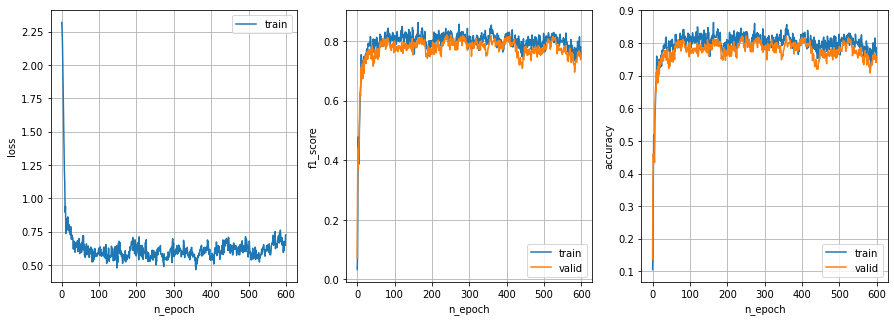

In [88]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(total_it), loss_train, label='train')
# plt.plot(range(total_it), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(total_it), f1_train, label='train')
plt.plot(range(total_it), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(total_it), acc_train, label='train')
plt.plot(range(total_it), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

In [89]:
#-- Evaluamos el modelo entrenado con el set de testeo
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.7085720300674438, f1: 0.765326890224775, acc: 0.7671371102333069


**Para el segundo modelo, configurado por los metaparámetros $(\text{n_epoch}, \text{learning_rate}, \text{weight_decay}, \text{batch_size}) = (100, 0.01, 0.01, 1024)$, se obtienen scores con un** *loss* **muy considerable y relativamente alto, y los scores** *f_1* **y** *accuracy* **son menores a 0.8, lo cual muestra que este modelo falla considerablemente al comparar los datos de predicción y de testeo.**

In [90]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

In [91]:
from sklearn.metrics import f1_score

def train_valid(model, n_epoch, optimizer, criterion):
  loss_train = []
  f1_train = []
  acc_train = []

  loss_valid = []
  f1_valid = []
  acc_valid = []

  for epoch in range(n_epoch):
    model.train()

    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

  print( 'Valid Evaluation loss: {}. f1:{} acc: {} '.format(loss_valid[-1], f1_valid[-1], acc_valid[-1]) )
  CM(Y_valid, Y_pred, 10)

  0%|          | 0/1 [00:00<?, ?it/s]

ne: 100, hd:100, wd:0.01, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.0676451921463013. f1:0.6624554613075253 acc: 0.6704999804496765 


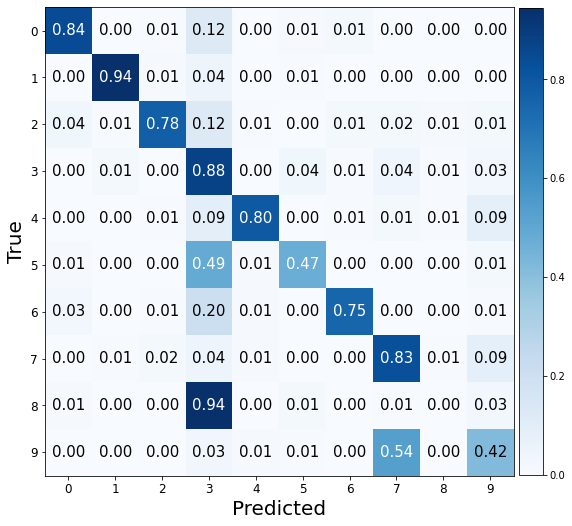

###################



In [92]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm


bs_list = [1024]
lr_list = [0.01]
wd_list = [0.01]
hd_list = [100]
ne_list = [100]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(hd_list)*len(ne_list))

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        for hd in hd_list:
          input_dim = 28*28
          out_dim = 10
          hidden = hd

          model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, out_dim)
          )

          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
          criterion = torch.nn.CrossEntropyLoss()

          print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
          train_valid(model,ne,optimizer,criterion)
          print('###################\n')

          pbar.update()
pbar.close()

**La matriz de confusión para el segundo modelo muestra fallas a la hora de reconocer el número 3 y lo confunde ampliamente con el número 8. Esto indica que los parámetros usados para el aprendizaje no fueron óptimos, a pesar de que,en comparación con el primer modelo, se incrementaron todos los metaparámetros. Por tanto, vemos que incrementar sin preocupación los metaparámetros no nos asegura que el modelo devuelva mejores resultados.**

**Se concluye entonces que el modelo 1 permite mejores resultados que el modelo 2. Más aún, los resultados del modelo 1 son muy buenos, lo cual nos permite comprender que parámetros cercanos a $(\text{n_epoch}, \text{learning_rate}, \text{weight_decay}, \text{batch_size}) = (50, 0.001, 0.001, 512)$ resultan ideales para la construcción del modelo ANN.**

**Para confirmar la anterior afirmación, consideremos matrices de confusión que consideren cada conjunto de metaparámetros usados:**

  0%|          | 0/16 [00:00<?, ?it/s]

ne: 50, hd:100, wd:0.001, lr: 0.001, bs:512 
Valid Evaluation loss: 0.7894233465194702. f1:0.8621331832731544 acc: 0.8619999885559082 


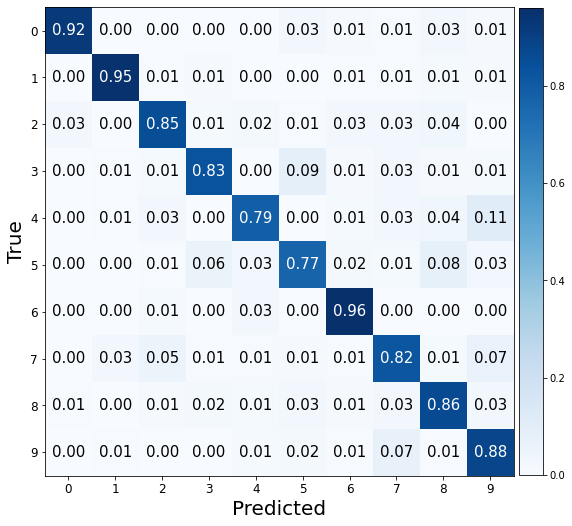

###################

ne: 50, hd:100, wd:0.01, lr: 0.001, bs:512 
Valid Evaluation loss: 0.851609468460083. f1:0.874254303383499 acc: 0.8740000128746033 


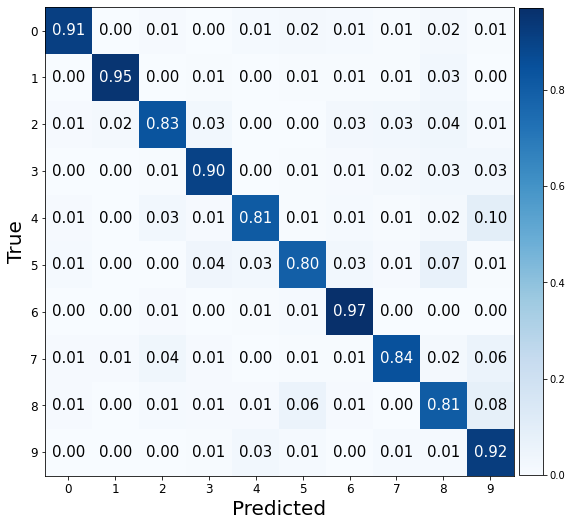

###################

ne: 50, hd:100, wd:0.001, lr: 0.01, bs:512 
Valid Evaluation loss: 1.369401454925537. f1:0.5159258485338588 acc: 0.5370000004768372 


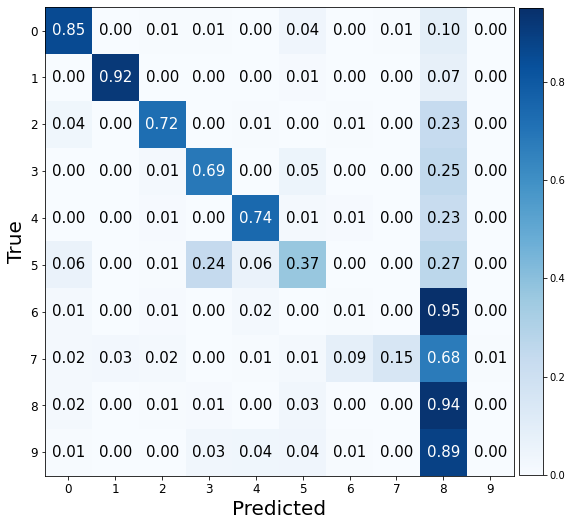

###################

ne: 50, hd:100, wd:0.01, lr: 0.01, bs:512 
Valid Evaluation loss: 1.3986589908599854. f1:0.6079320368113036 acc: 0.6050000190734863 


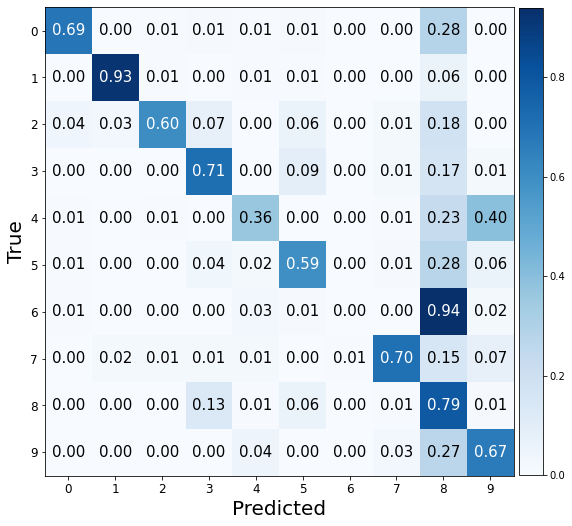

###################

ne: 50, hd:100, wd:0.001, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.8640334010124207. f1:0.8807774297701 acc: 0.8805000185966492 


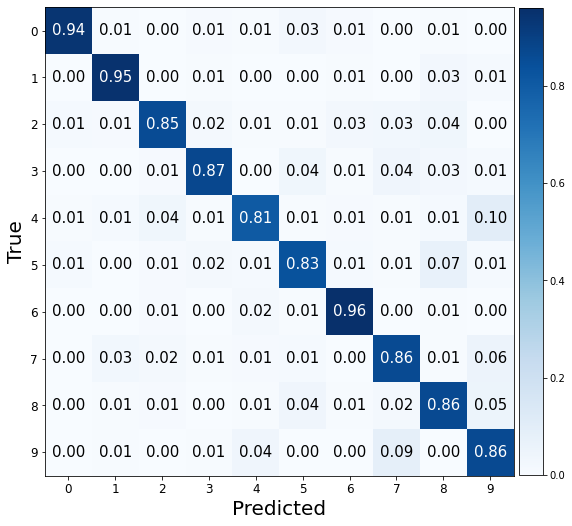

###################

ne: 50, hd:100, wd:0.01, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.6808162331581116. f1:0.8743612727857102 acc: 0.8740000128746033 


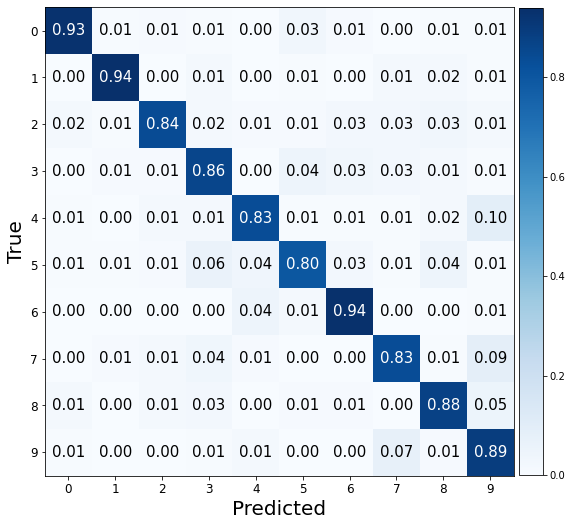

###################

ne: 50, hd:100, wd:0.001, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.1727229356765747. f1:0.677926145787336 acc: 0.6679999828338623 


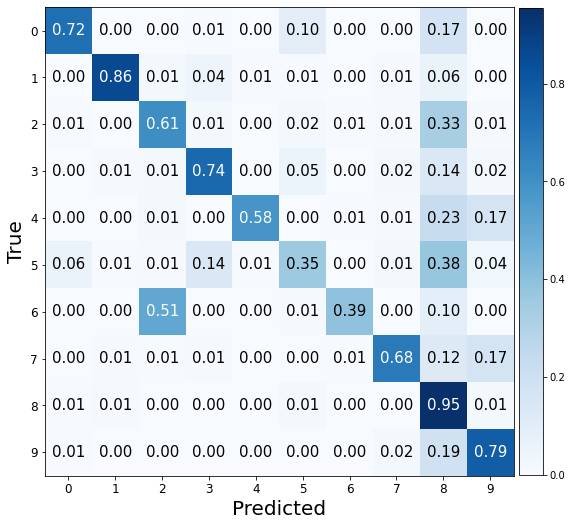

###################

ne: 50, hd:100, wd:0.01, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.7007282972335815. f1:0.39873461908381763 acc: 0.4244999885559082 


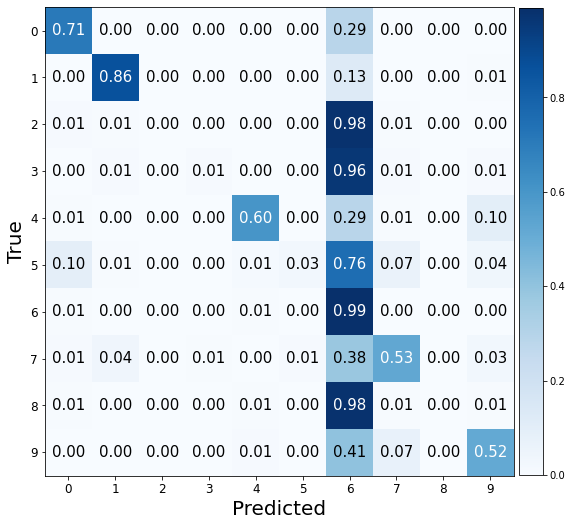

###################

ne: 100, hd:100, wd:0.001, lr: 0.001, bs:512 
Valid Evaluation loss: 0.6625686287879944. f1:0.8882108032685243 acc: 0.8880000114440918 


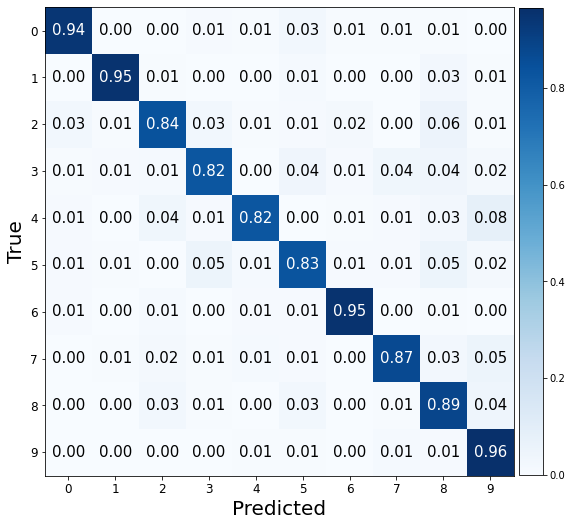

###################

ne: 100, hd:100, wd:0.01, lr: 0.001, bs:512 
Valid Evaluation loss: 0.7020133137702942. f1:0.8971443589892756 acc: 0.8970000147819519 


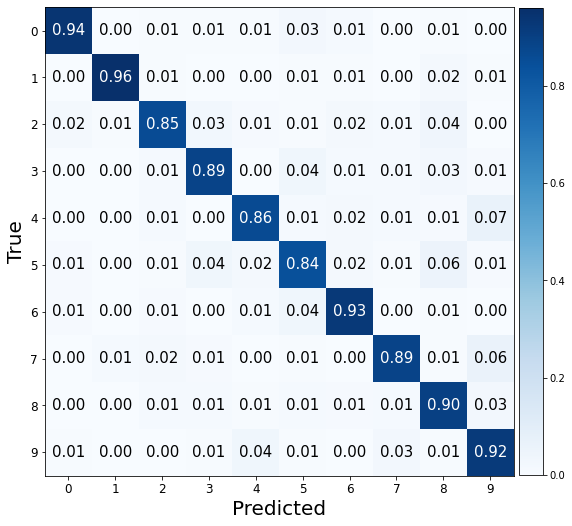

###################

ne: 100, hd:100, wd:0.001, lr: 0.01, bs:512 
Valid Evaluation loss: 1.1991630792617798. f1:0.6241102118621515 acc: 0.656000018119812 


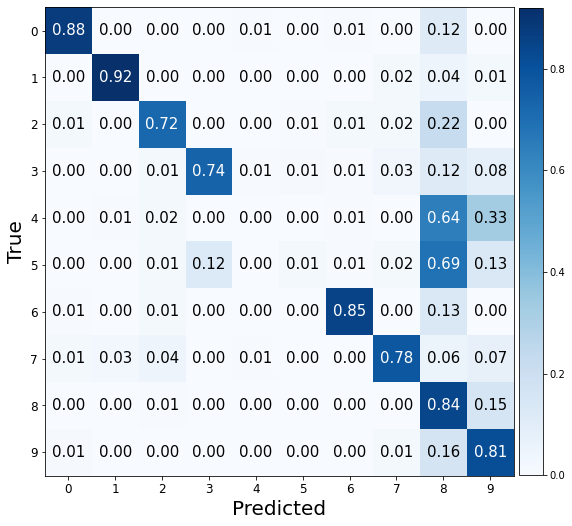

###################

ne: 100, hd:100, wd:0.01, lr: 0.01, bs:512 
Valid Evaluation loss: 1.0254566669464111. f1:0.7490837240002126 acc: 0.7394999861717224 


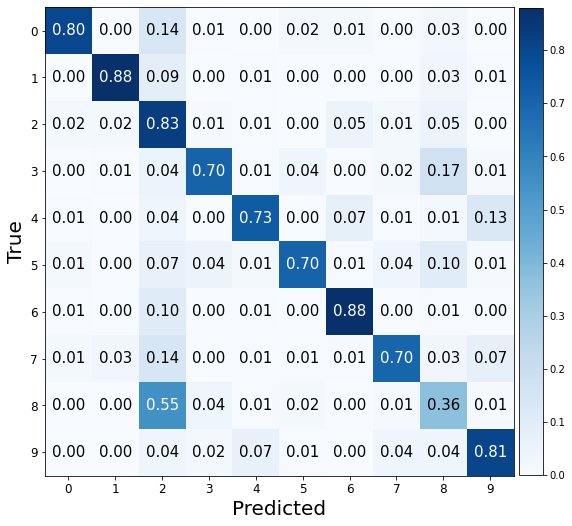

###################

ne: 100, hd:100, wd:0.001, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.7864639759063721. f1:0.8860069057713529 acc: 0.8859999775886536 


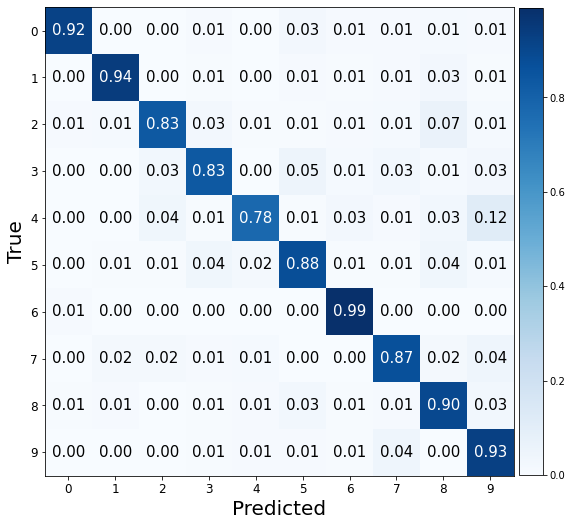

###################

ne: 100, hd:100, wd:0.01, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.5856777429580688. f1:0.8746335539593092 acc: 0.8744999766349792 


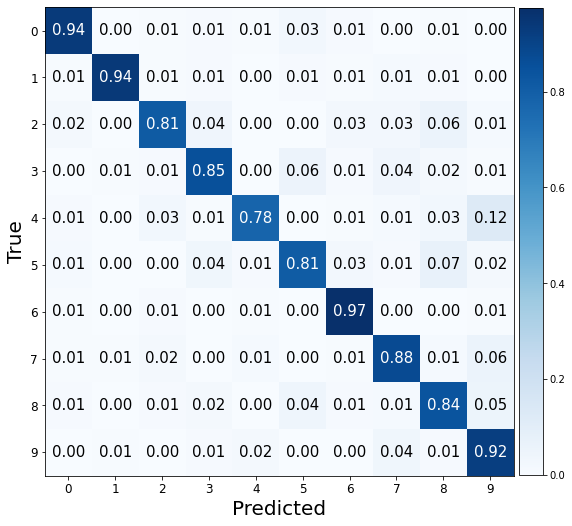

###################

ne: 100, hd:100, wd:0.001, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.012831449508667. f1:0.735167803444505 acc: 0.7384999990463257 


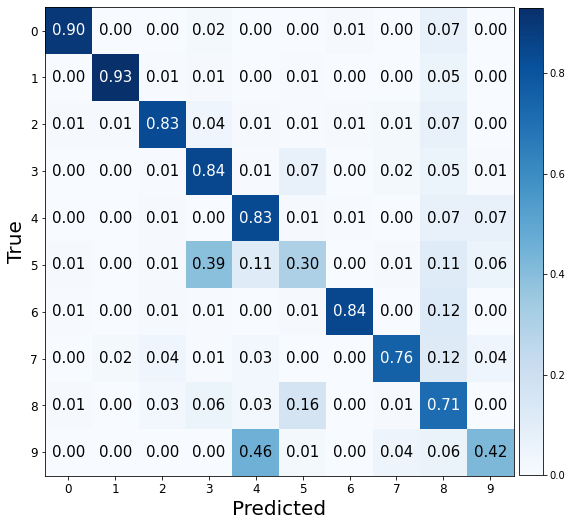

###################

ne: 100, hd:100, wd:0.01, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.3370167016983032. f1:0.5856615986324083 acc: 0.5979999899864197 


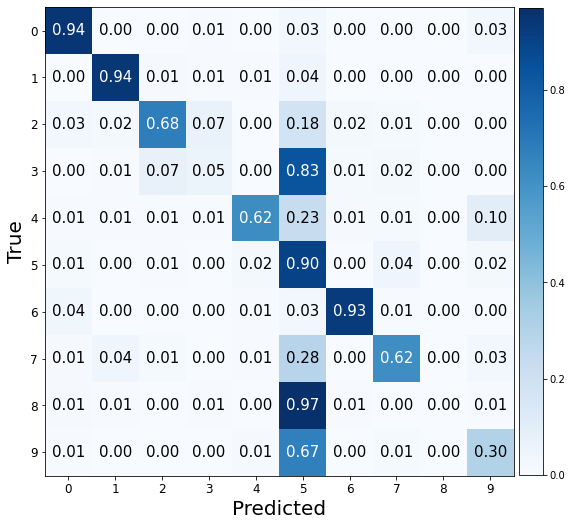

###################



In [93]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm


bs_list = [512,1024]
lr_list = [0.001,0.01]
wd_list = [0.001,0.01]
hd_list = [100]
ne_list = [50,100]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(hd_list)*len(ne_list))

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        for hd in hd_list:
          input_dim = 28*28
          out_dim = 10
          hidden = hd

          model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, out_dim)
          )

          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
          criterion = torch.nn.CrossEntropyLoss()

          print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
          train_valid(model,ne,optimizer,criterion)
          print('###################\n')

          pbar.update()
pbar.close()

**Las matrices de confusión nos muestran que los parámetros que dan mejores resultados están relacionados a un alto número de épocas, como era de esperarse, ya que permite a nuestro modelo tener un mayor número de "intentos" o posibilidades para practicar. También se nota que, aunque no es muy influyente, un** *weight_decay* **de 0.01 da mejores scores que uno de 0.001. El learnig_rate resulta ser muy importante, ya que si este parámetro es 0.001, los resultados son por mucho mejores que con 0.01. Finalmente, vemos que el batch_size es decisivo, ya que las diferencias entre 512 y 1024 resultan significativas, donde el valor de 512 nos da mejores resultados.**

**Así, se concluyen que los metaparámetros con mejores resultados son semejantes a $(\text{n_epoch}, \text{learning_rate}, \text{weight_decay}, \text{batch_size}) = (100, 0.001, 0.01, 512)$.**

**Así, como conclusión de este minireporte, vemos que los mejores resultados están optimizados por parámetros que complementen mejor las necesidades del modelo, y simplemente un número alto para todos los parámetros NO nos darán resultados ideales. Los scores y su correspondiente matriz de confusión muestran que la tupla de metaparámetros $(\text{n_epoch}, \text{learning_rate}, \text{weight_decay}, \text{batch_size}) = (100, 0.001, 0.01, 512)$ permite, dentro de los valores utilizados, el mejor modelo para la ANN.**